In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from pprint import pprint
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Activation, Dense, LeakyReLU, Dropout, BatchNormalization
from keras.losses import mean_squared_error, binary_crossentropy
from keras.optimizers import Adam, RMSprop
from keras import metrics
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers

Using TensorFlow backend.


In [3]:
start = datetime(2000,1,1)
end = datetime(2016,1,1)

In [4]:
original_data = pdr.get_data_yahoo('AAPL', start, end)
original_data.drop(['Volume', 'Adj Close'], axis=1, inplace=True)

In [5]:
# original_data.to_pickle('SPY.pkl')

In [6]:
# original_data = pd.read_pickle('SPY.pkl')

In [7]:
original_data.head()

,Open,High,Low,Close
Date,,,,
1999-12-31,3.604911,3.674107,3.553571,3.671875
2000-01-03,3.745536,4.017857,3.631696,3.997768
2000-01-04,3.866071,3.950893,3.613839,3.660714
2000-01-05,3.705357,3.948661,3.678571,3.714286
2000-01-06,3.790179,3.821429,3.392857,3.392857


### Create data representation

In [8]:
max_shift = 20

In [9]:
data = original_data.copy()
data.columns = pd.MultiIndex.from_product([['Shift 0'],['Open','High','Low','Close']])
for i in range(1, max_shift + 1):
    shifted = data.iloc[:,[0,1,2,3]].shift(i)
    shifted.columns = pd.MultiIndex.from_product([['Shift ' + str(i)],['Open','High','Low','Close']])
    data = pd.concat([data, shifted], axis=1)

In [10]:
data.head(6)

Shift 0                                 Shift 1            \
                Open      High       Low     Close      Open      High   
Date                                                                     
1999-12-31  3.604911  3.674107  3.553571  3.671875       NaN       NaN   
2000-01-03  3.745536  4.017857  3.631696  3.997768  3.604911  3.674107   
2000-01-04  3.866071  3.950893  3.613839  3.660714  3.745536  4.017857   
2000-01-05  3.705357  3.948661  3.678571  3.714286  3.866071  3.950893   
2000-01-06  3.790179  3.821429  3.392857  3.392857  3.705357  3.948661   
2000-01-07  3.446429  3.607143  3.410714  3.553571  3.790179  3.821429   

                                 Shift 2            ...  Shift 18        \
                 Low     Close      Open      High  ...       Low Close   
Date                                                ...                   
1999-12-31       NaN       NaN       NaN       NaN  ...       NaN   NaN   
2000-01-03  3.553571  3.671875       NaN       NaN  ...       NaN   NaN   
2000-01-04  3.631696  3.997768  3.604911  3.674107  ...       NaN   NaN   
2000-01-05  3.613839  3.660714  3.745536  4.017857  ...       NaN   NaN   
2000-01-06  3.678571  3.714286  3.866071  3.950893  ...       NaN   NaN   
2000-01-07  3.392857  3.392857  3.705357  3.948661  ...       NaN   NaN   

           Shift 19                Shift 20                 
               Open High Low Close     Open High Low Close  
Date                                                        
1999-12-31      NaN  NaN NaN   NaN      NaN  NaN NaN   NaN  
2000-01-03      NaN  NaN NaN   NaN      NaN  NaN NaN   NaN  
2000-01-04      NaN  NaN NaN   NaN      NaN  NaN NaN   NaN  
2000-01-05      NaN  NaN NaN   NaN      NaN  NaN NaN   NaN  
2000-01-06      NaN  NaN NaN   NaN      NaN  NaN NaN   NaN  
2000-01-07      NaN  NaN NaN   NaN      NaN  NaN NaN   NaN  

[6 rows x 84 columns]

In [11]:
data['Shift 2', 'Close'].head(3)

Date
1999-12-31         NaN
2000-01-03         NaN
2000-01-04    3.671875
Name: (Shift 2, Close), dtype: float64

In [12]:
for i in range(0, max_shift):
    cls = data['Shift ' + str(i), 'Close']
    opn = data['Shift ' + str(i), 'Open']
    data['Shift ' + str(i), 'Bull ' + str(i)] = 100 * (cls - opn) / cls

In [13]:
data['Shift 0'].head(2)

,Open,High,Low,Close,Bull 0
Date,,,,,
1999-12-31,3.604911,3.674107,3.553571,3.671875,1.823700
2000-01-03,3.745536,4.017857,3.631696,3.997768,6.309321


In [14]:
for i in range(0, max_shift):
    opn = data['Shift ' + str(i), 'Open']
    prv_cls = data['Shift ' + str(i+1), 'Close']
    data['Shift ' + str(i), 'GT ' + str(i)] = 100 * (opn - prv_cls) / opn

In [15]:
data[['Shift 0', 'Shift 1']].head()

Shift 0                                                     \
                Open      High       Low     Close     Bull 0      GT 0   
Date                                                                      
1999-12-31  3.604911  3.674107  3.553571  3.671875   1.823700       NaN   
2000-01-03  3.745536  4.017857  3.631696  3.997768   6.309321  1.966634   
2000-01-04  3.866071  3.950893  3.613839  3.660714  -5.609753 -3.406482   
2000-01-05  3.705357  3.948661  3.678571  3.714286   0.240396  1.204823   
2000-01-06  3.790179  3.821429  3.392857  3.392857 -11.710544  2.002359   

             Shift 1                                                    
                Open      High       Low     Close    Bull 1      GT 1  
Date                                                                    
1999-12-31       NaN       NaN       NaN       NaN       NaN       NaN  
2000-01-03  3.604911  3.674107  3.553571  3.671875  1.823700       NaN  
2000-01-04  3.745536  4.017857  3.631696  3.997768  6.309321  1.966634  
2000-01-05  3.866071  3.950893  3.613839  3.660714 -5.609753 -3.406482  
2000-01-06  3.705357  3.948661  3.678571  3.714286  0.240396  1.204823

In [16]:
shifted = data.iloc[:,[0,1,2,3]].shift(-5)
shifted.columns = pd.MultiIndex.from_product([['Shift -5'],['Open','High','Low','Close']])
data = pd.concat([data, shifted], axis=1)

In [17]:
cls_5 = data['Shift -5', 'Close']
cls = data['Shift 0', 'Close']
data['Shift 0', 'Return'] = 100 * (cls_5 - cls) / cls_5
data.head()

Shift 0                                 Shift 1            \
                Open      High       Low     Close      Open      High   
Date                                                                     
1999-12-31  3.604911  3.674107  3.553571  3.671875       NaN       NaN   
2000-01-03  3.745536  4.017857  3.631696  3.997768  3.604911  3.674107   
2000-01-04  3.866071  3.950893  3.613839  3.660714  3.745536  4.017857   
2000-01-05  3.705357  3.948661  3.678571  3.714286  3.866071  3.950893   
2000-01-06  3.790179  3.821429  3.392857  3.392857  3.705357  3.948661   

                                 Shift 2              ...     Shift 15  \
                 Low     Close      Open      High    ...        GT 15   
Date                                                  ...                
1999-12-31       NaN       NaN       NaN       NaN    ...          NaN   
2000-01-03  3.553571  3.671875       NaN       NaN    ...          NaN   
2000-01-04  3.631696  3.997768  3.604911  3.674107    ...          NaN   
2000-01-05  3.613839  3.660714  3.745536  4.017857    ...          NaN   
2000-01-06  3.678571  3.714286  3.866071  3.950893    ...          NaN   

           Shift 16 Shift 17 Shift 18 Shift 19  Shift -5                      \
              GT 16    GT 17    GT 18    GT 19      Open      High       Low   
Date                                                                           
1999-12-31      NaN      NaN      NaN      NaN  3.446429  3.607143  3.410714   
2000-01-03      NaN      NaN      NaN      NaN  3.642857  3.651786  3.383929   
2000-01-04      NaN      NaN      NaN      NaN  3.426339  3.549107  3.232143   
2000-01-05      NaN      NaN      NaN      NaN  3.392857  3.410714  3.089286   
2000-01-06      NaN      NaN      NaN      NaN  3.374439  3.526786  3.303571   

                        Shift 0  
               Close     Return  
Date                             
1999-12-31  3.553571  -3.329158  
2000-01-03  3.491071 -14.514085  
2000-01-04  3.312500 -10.512121  
2000-01-05  3.113839 -19.283174  
2000-01-06  3.455357   1.808786  

[5 rows x 129 columns]

In [18]:
binary_data = data.drop(['Open', 'High', 'Low', 'Close'], axis=1, level=1)
binary_data.head()

,Shift 0,Shift 1,Shift 2,Shift 3,Shift 4,Shift 5,Shift 6,Shift 7,Shift 8,Shift 9,...,Shift 11,Shift 12,Shift 13,Shift 14,Shift 15,Shift 16,Shift 17,Shift 18,Shift 19,Shift 0
,Bull 0,Bull 1,Bull 2,Bull 3,Bull 4,Bull 5,Bull 6,Bull 7,Bull 8,Bull 9,...,GT 11,GT 12,GT 13,GT 14,GT 15,GT 16,GT 17,GT 18,GT 19,Return
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,1.823700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.329158
2000-01-03,6.309321,1.823700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-14.514085
2000-01-04,-5.609753,6.309321,1.823700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.512121
2000-01-05,0.240396,-5.609753,6.309321,1.823700,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-19.283174
2000-01-06,-11.710544,0.240396,-5.609753,6.309321,1.8237,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.808786


In [19]:
binary_data.columns = binary_data.columns.droplevel()

In [20]:
binary_data.head(10)

,Bull 0,Bull 1,Bull 2,Bull 3,Bull 4,Bull 5,Bull 6,Bull 7,Bull 8,Bull 9,...,GT 11,GT 12,GT 13,GT 14,GT 15,GT 16,GT 17,GT 18,GT 19,Return
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,1.823700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.329158
2000-01-03,6.309321,1.823700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-14.514085
2000-01-04,-5.609753,6.309321,1.823700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.512121
2000-01-05,0.240396,-5.609753,6.309321,1.823700,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-19.283174
2000-01-06,-11.710544,0.240396,-5.609753,6.309321,1.823700,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.808786
2000-01-07,3.015052,-11.710544,0.240396,-5.609753,6.309321,1.823700,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.933440
2000-01-10,-4.347835,3.015052,-11.710544,0.240396,-5.609753,6.309321,1.823700,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.953119
2000-01-11,-3.436649,-4.347835,3.015052,-11.710544,0.240396,-5.609753,6.309321,1.823700,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.961887
2000-01-12,-8.960579,-3.436649,-4.347835,3.015052,-11.710544,0.240396,-5.609753,6.309321,1.823700,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.182818


# Train Keras NN

### Setup X_train, X_test, etc

In [21]:
binary_data.dropna(inplace=True)

In [22]:
X = binary_data.drop('Return', axis=1)
y = binary_data['Return'] > 0
y = np.expand_dims(y, axis=1)
y = np.hstack((y, 1 - y))

In [23]:
returns = binary_data['Return']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Build model

In [26]:
model = Sequential()
model.add(Dense(100, input_dim=X.shape[1], kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(80, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(50, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(30, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(15, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(2, kernel_initializer='uniform'))
model.add(Activation('softmax'))

model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=2000, 
          batch_size=256, 
          verbose=2)

Train on 3200 samples, validate on 801 samples
Epoch 1/2000
3s - loss: 0.6922 - acc: 0.5150 - val_loss: 0.6927 - val_acc: 0.5218
Epoch 2/2000
0s - loss: 0.6885 - acc: 0.5603 - val_loss: 0.6924 - val_acc: 0.5218
Epoch 3/2000
0s - loss: 0.6828 - acc: 0.5737 - val_loss: 0.6922 - val_acc: 0.5218
Epoch 4/2000
0s - loss: 0.6787 - acc: 0.5772 - val_loss: 0.6922 - val_acc: 0.5218
Epoch 5/2000
0s - loss: 0.6780 - acc: 0.5778 - val_loss: 0.6924 - val_acc: 0.5218
Epoch 6/2000
0s - loss: 0.6724 - acc: 0.5953 - val_loss: 0.6927 - val_acc: 0.5218
Epoch 7/2000
0s - loss: 0.6717 - acc: 0.5975 - val_loss: 0.6932 - val_acc: 0.5218
Epoch 8/2000
0s - loss: 0.6660 - acc: 0.6047 - val_loss: 0.6938 - val_acc: 0.5218
Epoch 9/2000
0s - loss: 0.6624 - acc: 0.6131 - val_loss: 0.6945 - val_acc: 0.5218
Epoch 10/2000
0s - loss: 0.6626 - acc: 0.6059 - val_loss: 0.6955 - val_acc: 0.5218
Epoch 11/2000
0s - loss: 0.6547 - acc: 0.6175 - val_loss: 0.6969 - val_acc: 0.5218
Epoch 12/2000
0s - loss: 0.6507 - acc: 0.6225 - v

0s - loss: 0.4646 - acc: 0.7753 - val_loss: 0.9421 - val_acc: 0.5393
Epoch 102/2000
0s - loss: 0.4521 - acc: 0.7922 - val_loss: 0.9394 - val_acc: 0.5393
Epoch 103/2000
0s - loss: 0.4472 - acc: 0.7922 - val_loss: 0.9386 - val_acc: 0.5443
Epoch 104/2000
0s - loss: 0.4646 - acc: 0.7909 - val_loss: 0.9577 - val_acc: 0.5393
Epoch 105/2000
0s - loss: 0.4622 - acc: 0.7787 - val_loss: 0.9393 - val_acc: 0.5368
Epoch 106/2000
0s - loss: 0.4448 - acc: 0.7978 - val_loss: 0.9749 - val_acc: 0.5456
Epoch 107/2000
0s - loss: 0.4571 - acc: 0.7831 - val_loss: 0.9338 - val_acc: 0.5418
Epoch 108/2000
0s - loss: 0.4414 - acc: 0.7997 - val_loss: 0.9468 - val_acc: 0.5443
Epoch 109/2000
0s - loss: 0.4432 - acc: 0.7878 - val_loss: 0.9684 - val_acc: 0.5381
Epoch 110/2000
0s - loss: 0.4466 - acc: 0.7922 - val_loss: 1.0040 - val_acc: 0.5406
Epoch 111/2000
0s - loss: 0.4457 - acc: 0.7937 - val_loss: 0.9977 - val_acc: 0.5393
Epoch 112/2000
0s - loss: 0.4469 - acc: 0.7944 - val_loss: 1.0040 - val_acc: 0.5393
Epoch 1

0s - loss: 0.3591 - acc: 0.8469 - val_loss: 1.1165 - val_acc: 0.5343
Epoch 200/2000
0s - loss: 0.3802 - acc: 0.8319 - val_loss: 1.1231 - val_acc: 0.5493
Epoch 201/2000
0s - loss: 0.3707 - acc: 0.8391 - val_loss: 1.1002 - val_acc: 0.5431
Epoch 202/2000
0s - loss: 0.3904 - acc: 0.8225 - val_loss: 1.1324 - val_acc: 0.5456
Epoch 203/2000
0s - loss: 0.3760 - acc: 0.8350 - val_loss: 1.1384 - val_acc: 0.5368
Epoch 204/2000
0s - loss: 0.3701 - acc: 0.8366 - val_loss: 1.1319 - val_acc: 0.5381
Epoch 205/2000
0s - loss: 0.3752 - acc: 0.8397 - val_loss: 1.1166 - val_acc: 0.5468
Epoch 206/2000
0s - loss: 0.3842 - acc: 0.8303 - val_loss: 1.1276 - val_acc: 0.5381
Epoch 207/2000
0s - loss: 0.3910 - acc: 0.8303 - val_loss: 1.1334 - val_acc: 0.5393
Epoch 208/2000
0s - loss: 0.3654 - acc: 0.8341 - val_loss: 1.1329 - val_acc: 0.5468
Epoch 209/2000
0s - loss: 0.3819 - acc: 0.8416 - val_loss: 1.1120 - val_acc: 0.5356
Epoch 210/2000
0s - loss: 0.3706 - acc: 0.8412 - val_loss: 1.1093 - val_acc: 0.5306
Epoch 2

0s - loss: 0.3517 - acc: 0.8525 - val_loss: 1.1865 - val_acc: 0.5293
Epoch 298/2000
0s - loss: 0.3424 - acc: 0.8625 - val_loss: 1.1885 - val_acc: 0.5368
Epoch 299/2000
0s - loss: 0.3310 - acc: 0.8581 - val_loss: 1.1886 - val_acc: 0.5381
Epoch 300/2000
0s - loss: 0.3540 - acc: 0.8534 - val_loss: 1.1820 - val_acc: 0.5293
Epoch 301/2000
0s - loss: 0.3471 - acc: 0.8500 - val_loss: 1.2200 - val_acc: 0.5268
Epoch 302/2000
0s - loss: 0.3430 - acc: 0.8466 - val_loss: 1.2188 - val_acc: 0.5256
Epoch 303/2000
0s - loss: 0.3485 - acc: 0.8531 - val_loss: 1.2432 - val_acc: 0.5231
Epoch 304/2000
0s - loss: 0.3568 - acc: 0.8488 - val_loss: 1.2647 - val_acc: 0.5293
Epoch 305/2000
0s - loss: 0.3506 - acc: 0.8581 - val_loss: 1.2134 - val_acc: 0.5331
Epoch 306/2000
0s - loss: 0.3588 - acc: 0.8466 - val_loss: 1.2041 - val_acc: 0.5218
Epoch 307/2000
0s - loss: 0.3418 - acc: 0.8578 - val_loss: 1.1913 - val_acc: 0.5206
Epoch 308/2000
0s - loss: 0.3421 - acc: 0.8572 - val_loss: 1.2468 - val_acc: 0.5368
Epoch 3

Epoch 396/2000
0s - loss: 0.3251 - acc: 0.8669 - val_loss: 1.2999 - val_acc: 0.5318
Epoch 397/2000
0s - loss: 0.2958 - acc: 0.8791 - val_loss: 1.2745 - val_acc: 0.5318
Epoch 398/2000
0s - loss: 0.3267 - acc: 0.8647 - val_loss: 1.2587 - val_acc: 0.5381
Epoch 399/2000
0s - loss: 0.3296 - acc: 0.8691 - val_loss: 1.2538 - val_acc: 0.5343
Epoch 400/2000
0s - loss: 0.3285 - acc: 0.8616 - val_loss: 1.2420 - val_acc: 0.5293
Epoch 401/2000
0s - loss: 0.3282 - acc: 0.8663 - val_loss: 1.2268 - val_acc: 0.5306
Epoch 402/2000
0s - loss: 0.3270 - acc: 0.8694 - val_loss: 1.2202 - val_acc: 0.5381
Epoch 403/2000
0s - loss: 0.3182 - acc: 0.8653 - val_loss: 1.2220 - val_acc: 0.5431
Epoch 404/2000
0s - loss: 0.3214 - acc: 0.8691 - val_loss: 1.2509 - val_acc: 0.5506
Epoch 405/2000
0s - loss: 0.3254 - acc: 0.8641 - val_loss: 1.2301 - val_acc: 0.5506
Epoch 406/2000
0s - loss: 0.3341 - acc: 0.8684 - val_loss: 1.2180 - val_acc: 0.5406
Epoch 407/2000
0s - loss: 0.3451 - acc: 0.8581 - val_loss: 1.2152 - val_acc:

0s - loss: 0.3041 - acc: 0.8759 - val_loss: 1.3041 - val_acc: 0.5393
Epoch 496/2000
0s - loss: 0.3296 - acc: 0.8694 - val_loss: 1.2960 - val_acc: 0.5418
Epoch 497/2000
0s - loss: 0.3038 - acc: 0.8747 - val_loss: 1.3034 - val_acc: 0.5368
Epoch 498/2000
0s - loss: 0.3060 - acc: 0.8781 - val_loss: 1.3105 - val_acc: 0.5356
Epoch 499/2000
0s - loss: 0.3134 - acc: 0.8734 - val_loss: 1.3292 - val_acc: 0.5306
Epoch 500/2000
0s - loss: 0.3105 - acc: 0.8744 - val_loss: 1.3253 - val_acc: 0.5306
Epoch 501/2000
0s - loss: 0.3035 - acc: 0.8756 - val_loss: 1.3591 - val_acc: 0.5281
Epoch 502/2000
0s - loss: 0.3134 - acc: 0.8716 - val_loss: 1.3317 - val_acc: 0.5343
Epoch 503/2000
0s - loss: 0.2776 - acc: 0.8881 - val_loss: 1.3624 - val_acc: 0.5318
Epoch 504/2000
0s - loss: 0.3209 - acc: 0.8744 - val_loss: 1.3470 - val_acc: 0.5343
Epoch 505/2000
0s - loss: 0.3077 - acc: 0.8728 - val_loss: 1.3216 - val_acc: 0.5343
Epoch 506/2000
0s - loss: 0.3164 - acc: 0.8725 - val_loss: 1.3087 - val_acc: 0.5406
Epoch 5

0s - loss: 0.2854 - acc: 0.8800 - val_loss: 1.2914 - val_acc: 0.5331
Epoch 594/2000
0s - loss: 0.2990 - acc: 0.8831 - val_loss: 1.3070 - val_acc: 0.5343
Epoch 595/2000
0s - loss: 0.2792 - acc: 0.8884 - val_loss: 1.3120 - val_acc: 0.5356
Epoch 596/2000
0s - loss: 0.2983 - acc: 0.8750 - val_loss: 1.2930 - val_acc: 0.5381
Epoch 597/2000
0s - loss: 0.3100 - acc: 0.8778 - val_loss: 1.2882 - val_acc: 0.5418
Epoch 598/2000
0s - loss: 0.3017 - acc: 0.8738 - val_loss: 1.3021 - val_acc: 0.5393
Epoch 599/2000
0s - loss: 0.3190 - acc: 0.8738 - val_loss: 1.2788 - val_acc: 0.5393
Epoch 600/2000
0s - loss: 0.3075 - acc: 0.8744 - val_loss: 1.2778 - val_acc: 0.5356
Epoch 601/2000
0s - loss: 0.2997 - acc: 0.8716 - val_loss: 1.3154 - val_acc: 0.5356
Epoch 602/2000
0s - loss: 0.3098 - acc: 0.8672 - val_loss: 1.3044 - val_acc: 0.5418
Epoch 603/2000
0s - loss: 0.2977 - acc: 0.8784 - val_loss: 1.3223 - val_acc: 0.5406
Epoch 604/2000
0s - loss: 0.2995 - acc: 0.8744 - val_loss: 1.3414 - val_acc: 0.5381
Epoch 6

0s - loss: 0.2901 - acc: 0.8809 - val_loss: 1.3179 - val_acc: 0.5381
Epoch 692/2000
0s - loss: 0.3044 - acc: 0.8712 - val_loss: 1.3512 - val_acc: 0.5393
Epoch 693/2000
0s - loss: 0.2985 - acc: 0.8884 - val_loss: 1.3557 - val_acc: 0.5406
Epoch 694/2000
0s - loss: 0.2946 - acc: 0.8788 - val_loss: 1.3439 - val_acc: 0.5343
Epoch 695/2000
0s - loss: 0.2866 - acc: 0.8844 - val_loss: 1.3005 - val_acc: 0.5343
Epoch 696/2000
0s - loss: 0.2856 - acc: 0.8809 - val_loss: 1.2985 - val_acc: 0.5318
Epoch 697/2000
0s - loss: 0.3023 - acc: 0.8772 - val_loss: 1.3651 - val_acc: 0.5356
Epoch 698/2000
0s - loss: 0.3081 - acc: 0.8772 - val_loss: 1.3647 - val_acc: 0.5393
Epoch 699/2000
0s - loss: 0.2936 - acc: 0.8756 - val_loss: 1.3419 - val_acc: 0.5418
Epoch 700/2000
0s - loss: 0.2654 - acc: 0.8906 - val_loss: 1.3867 - val_acc: 0.5381
Epoch 701/2000
0s - loss: 0.3082 - acc: 0.8744 - val_loss: 1.3940 - val_acc: 0.5343
Epoch 702/2000
0s - loss: 0.2996 - acc: 0.8844 - val_loss: 1.3464 - val_acc: 0.5243
Epoch 7

0s - loss: 0.2886 - acc: 0.8828 - val_loss: 1.3992 - val_acc: 0.5268
Epoch 791/2000
0s - loss: 0.2714 - acc: 0.8969 - val_loss: 1.3614 - val_acc: 0.5343
Epoch 792/2000
0s - loss: 0.2977 - acc: 0.8856 - val_loss: 1.3569 - val_acc: 0.5331
Epoch 793/2000
0s - loss: 0.3197 - acc: 0.8687 - val_loss: 1.3206 - val_acc: 0.5368
Epoch 794/2000
0s - loss: 0.2602 - acc: 0.8944 - val_loss: 1.3349 - val_acc: 0.5331
Epoch 795/2000
0s - loss: 0.2780 - acc: 0.8928 - val_loss: 1.3703 - val_acc: 0.5331
Epoch 796/2000
0s - loss: 0.2969 - acc: 0.8819 - val_loss: 1.3450 - val_acc: 0.5331
Epoch 797/2000
0s - loss: 0.2717 - acc: 0.8903 - val_loss: 1.3315 - val_acc: 0.5268
Epoch 798/2000
0s - loss: 0.2940 - acc: 0.8772 - val_loss: 1.3787 - val_acc: 0.5306
Epoch 799/2000
0s - loss: 0.2665 - acc: 0.8934 - val_loss: 1.3736 - val_acc: 0.5293
Epoch 800/2000
0s - loss: 0.2981 - acc: 0.8769 - val_loss: 1.3459 - val_acc: 0.5306
Epoch 801/2000
0s - loss: 0.2919 - acc: 0.8816 - val_loss: 1.3217 - val_acc: 0.5318
Epoch 8

0s - loss: 0.2751 - acc: 0.8813 - val_loss: 1.3925 - val_acc: 0.5331
Epoch 889/2000
0s - loss: 0.2764 - acc: 0.8847 - val_loss: 1.4204 - val_acc: 0.5318
Epoch 890/2000
0s - loss: 0.2944 - acc: 0.8850 - val_loss: 1.4246 - val_acc: 0.5331
Epoch 891/2000
0s - loss: 0.2770 - acc: 0.8825 - val_loss: 1.3964 - val_acc: 0.5356
Epoch 892/2000
0s - loss: 0.2908 - acc: 0.8794 - val_loss: 1.3891 - val_acc: 0.5331
Epoch 893/2000
0s - loss: 0.2862 - acc: 0.8850 - val_loss: 1.3932 - val_acc: 0.5368
Epoch 894/2000
0s - loss: 0.2974 - acc: 0.8753 - val_loss: 1.3634 - val_acc: 0.5356
Epoch 895/2000
0s - loss: 0.2851 - acc: 0.8894 - val_loss: 1.3580 - val_acc: 0.5368
Epoch 896/2000
0s - loss: 0.2815 - acc: 0.8878 - val_loss: 1.3538 - val_acc: 0.5306
Epoch 897/2000
0s - loss: 0.2667 - acc: 0.8916 - val_loss: 1.3469 - val_acc: 0.5331
Epoch 898/2000
0s - loss: 0.2746 - acc: 0.8941 - val_loss: 1.3075 - val_acc: 0.5318
Epoch 899/2000
0s - loss: 0.2912 - acc: 0.8875 - val_loss: 1.3253 - val_acc: 0.5343
Epoch 9

0s - loss: 0.2877 - acc: 0.8853 - val_loss: 1.4444 - val_acc: 0.5306
Epoch 987/2000
0s - loss: 0.2864 - acc: 0.8859 - val_loss: 1.4570 - val_acc: 0.5231
Epoch 988/2000
0s - loss: 0.2697 - acc: 0.8947 - val_loss: 1.4201 - val_acc: 0.5206
Epoch 989/2000
0s - loss: 0.2806 - acc: 0.8947 - val_loss: 1.4047 - val_acc: 0.5293
Epoch 990/2000
0s - loss: 0.2677 - acc: 0.8894 - val_loss: 1.4164 - val_acc: 0.5231
Epoch 991/2000
0s - loss: 0.2621 - acc: 0.8903 - val_loss: 1.4345 - val_acc: 0.5243
Epoch 992/2000
0s - loss: 0.2638 - acc: 0.8922 - val_loss: 1.4750 - val_acc: 0.5194
Epoch 993/2000
0s - loss: 0.2616 - acc: 0.9003 - val_loss: 1.4840 - val_acc: 0.5281
Epoch 994/2000
0s - loss: 0.2840 - acc: 0.8872 - val_loss: 1.4726 - val_acc: 0.5281
Epoch 995/2000
0s - loss: 0.2804 - acc: 0.8759 - val_loss: 1.4788 - val_acc: 0.5256
Epoch 996/2000
0s - loss: 0.2732 - acc: 0.8872 - val_loss: 1.4741 - val_acc: 0.5218
Epoch 997/2000
0s - loss: 0.2947 - acc: 0.8850 - val_loss: 1.4446 - val_acc: 0.5268
Epoch 9

0s - loss: 0.2761 - acc: 0.8856 - val_loss: 1.4017 - val_acc: 0.5318
Epoch 1085/2000
0s - loss: 0.2603 - acc: 0.8966 - val_loss: 1.4316 - val_acc: 0.5256
Epoch 1086/2000
0s - loss: 0.2761 - acc: 0.8897 - val_loss: 1.4543 - val_acc: 0.5306
Epoch 1087/2000
0s - loss: 0.2819 - acc: 0.8859 - val_loss: 1.4334 - val_acc: 0.5318
Epoch 1088/2000
0s - loss: 0.2718 - acc: 0.8853 - val_loss: 1.4374 - val_acc: 0.5256
Epoch 1089/2000
0s - loss: 0.2704 - acc: 0.8906 - val_loss: 1.4197 - val_acc: 0.5281
Epoch 1090/2000
0s - loss: 0.2771 - acc: 0.8888 - val_loss: 1.4434 - val_acc: 0.5293
Epoch 1091/2000
0s - loss: 0.2670 - acc: 0.8944 - val_loss: 1.4208 - val_acc: 0.5306
Epoch 1092/2000
0s - loss: 0.2712 - acc: 0.8909 - val_loss: 1.4216 - val_acc: 0.5318
Epoch 1093/2000
0s - loss: 0.2652 - acc: 0.8897 - val_loss: 1.4368 - val_acc: 0.5318
Epoch 1094/2000
0s - loss: 0.2728 - acc: 0.8894 - val_loss: 1.4404 - val_acc: 0.5318
Epoch 1095/2000
0s - loss: 0.2781 - acc: 0.8912 - val_loss: 1.4323 - val_acc: 0.5

0s - loss: 0.2768 - acc: 0.8866 - val_loss: 1.4254 - val_acc: 0.5318
Epoch 1183/2000
0s - loss: 0.2608 - acc: 0.8956 - val_loss: 1.4141 - val_acc: 0.5318
Epoch 1184/2000
0s - loss: 0.2749 - acc: 0.8856 - val_loss: 1.4174 - val_acc: 0.5281
Epoch 1185/2000
0s - loss: 0.2436 - acc: 0.9069 - val_loss: 1.4236 - val_acc: 0.5331
Epoch 1186/2000
0s - loss: 0.2763 - acc: 0.8894 - val_loss: 1.4129 - val_acc: 0.5343
Epoch 1187/2000
0s - loss: 0.2562 - acc: 0.8972 - val_loss: 1.4126 - val_acc: 0.5306
Epoch 1188/2000
0s - loss: 0.2955 - acc: 0.8822 - val_loss: 1.4171 - val_acc: 0.5306
Epoch 1189/2000
0s - loss: 0.2628 - acc: 0.8953 - val_loss: 1.4096 - val_acc: 0.5306
Epoch 1190/2000
0s - loss: 0.2684 - acc: 0.8962 - val_loss: 1.3986 - val_acc: 0.5293
Epoch 1191/2000
0s - loss: 0.2649 - acc: 0.8928 - val_loss: 1.3670 - val_acc: 0.5318
Epoch 1192/2000
0s - loss: 0.2746 - acc: 0.8928 - val_loss: 1.3492 - val_acc: 0.5331
Epoch 1193/2000
0s - loss: 0.2636 - acc: 0.8912 - val_loss: 1.3777 - val_acc: 0.5

0s - loss: 0.2740 - acc: 0.8903 - val_loss: 1.4136 - val_acc: 0.5243
Epoch 1281/2000
0s - loss: 0.2714 - acc: 0.8997 - val_loss: 1.3926 - val_acc: 0.5243
Epoch 1282/2000
0s - loss: 0.2685 - acc: 0.8953 - val_loss: 1.3832 - val_acc: 0.5218
Epoch 1283/2000
0s - loss: 0.2484 - acc: 0.9009 - val_loss: 1.3891 - val_acc: 0.5281
Epoch 1284/2000
0s - loss: 0.2582 - acc: 0.8966 - val_loss: 1.4326 - val_acc: 0.5368
Epoch 1285/2000
0s - loss: 0.2824 - acc: 0.8856 - val_loss: 1.4316 - val_acc: 0.5356
Epoch 1286/2000
0s - loss: 0.2631 - acc: 0.8919 - val_loss: 1.4215 - val_acc: 0.5331
Epoch 1287/2000
0s - loss: 0.2662 - acc: 0.8919 - val_loss: 1.4274 - val_acc: 0.5331
Epoch 1288/2000
0s - loss: 0.2682 - acc: 0.8947 - val_loss: 1.4364 - val_acc: 0.5368
Epoch 1289/2000
0s - loss: 0.2800 - acc: 0.8866 - val_loss: 1.4266 - val_acc: 0.5368
Epoch 1290/2000
0s - loss: 0.2481 - acc: 0.9025 - val_loss: 1.4245 - val_acc: 0.5318
Epoch 1291/2000
0s - loss: 0.2511 - acc: 0.8981 - val_loss: 1.4328 - val_acc: 0.5

0s - loss: 0.2641 - acc: 0.9003 - val_loss: 1.3882 - val_acc: 0.5306
Epoch 1379/2000
0s - loss: 0.2467 - acc: 0.9006 - val_loss: 1.3947 - val_acc: 0.5356
Epoch 1380/2000
0s - loss: 0.2386 - acc: 0.9053 - val_loss: 1.4320 - val_acc: 0.5356
Epoch 1381/2000
0s - loss: 0.2667 - acc: 0.8916 - val_loss: 1.4744 - val_acc: 0.5381
Epoch 1382/2000
0s - loss: 0.2531 - acc: 0.8959 - val_loss: 1.5093 - val_acc: 0.5368
Epoch 1383/2000
0s - loss: 0.2646 - acc: 0.8931 - val_loss: 1.5332 - val_acc: 0.5356
Epoch 1384/2000
0s - loss: 0.2545 - acc: 0.9041 - val_loss: 1.5095 - val_acc: 0.5318
Epoch 1385/2000
0s - loss: 0.2753 - acc: 0.8922 - val_loss: 1.5242 - val_acc: 0.5343
Epoch 1386/2000
0s - loss: 0.2572 - acc: 0.8972 - val_loss: 1.5247 - val_acc: 0.5356
Epoch 1387/2000
0s - loss: 0.2520 - acc: 0.9003 - val_loss: 1.5098 - val_acc: 0.5343
Epoch 1388/2000
0s - loss: 0.2598 - acc: 0.8972 - val_loss: 1.4969 - val_acc: 0.5318
Epoch 1389/2000
0s - loss: 0.2764 - acc: 0.8903 - val_loss: 1.4752 - val_acc: 0.5

0s - loss: 0.2620 - acc: 0.8891 - val_loss: 1.4659 - val_acc: 0.5256
Epoch 1477/2000
0s - loss: 0.2521 - acc: 0.9022 - val_loss: 1.5120 - val_acc: 0.5256
Epoch 1478/2000
0s - loss: 0.2659 - acc: 0.8953 - val_loss: 1.4907 - val_acc: 0.5281
Epoch 1479/2000
0s - loss: 0.2553 - acc: 0.8956 - val_loss: 1.4836 - val_acc: 0.5306
Epoch 1480/2000
0s - loss: 0.2616 - acc: 0.8984 - val_loss: 1.4699 - val_acc: 0.5293
Epoch 1481/2000
0s - loss: 0.2857 - acc: 0.8919 - val_loss: 1.4722 - val_acc: 0.5318
Epoch 1482/2000
0s - loss: 0.2603 - acc: 0.9006 - val_loss: 1.4558 - val_acc: 0.5306
Epoch 1483/2000
0s - loss: 0.2679 - acc: 0.8938 - val_loss: 1.4607 - val_acc: 0.5331
Epoch 1484/2000
0s - loss: 0.2651 - acc: 0.8931 - val_loss: 1.4878 - val_acc: 0.5318
Epoch 1485/2000
0s - loss: 0.2467 - acc: 0.9081 - val_loss: 1.4840 - val_acc: 0.5268
Epoch 1486/2000
0s - loss: 0.2666 - acc: 0.9016 - val_loss: 1.4773 - val_acc: 0.5256
Epoch 1487/2000
0s - loss: 0.2735 - acc: 0.8969 - val_loss: 1.4753 - val_acc: 0.5

0s - loss: 0.2541 - acc: 0.8981 - val_loss: 1.5109 - val_acc: 0.5381
Epoch 1575/2000
0s - loss: 0.2410 - acc: 0.9009 - val_loss: 1.5212 - val_acc: 0.5356
Epoch 1576/2000
0s - loss: 0.2534 - acc: 0.9047 - val_loss: 1.4993 - val_acc: 0.5343
Epoch 1577/2000
0s - loss: 0.2729 - acc: 0.8894 - val_loss: 1.4878 - val_acc: 0.5381
Epoch 1578/2000
0s - loss: 0.2431 - acc: 0.9034 - val_loss: 1.4896 - val_acc: 0.5381
Epoch 1579/2000
0s - loss: 0.2538 - acc: 0.8975 - val_loss: 1.4795 - val_acc: 0.5343
Epoch 1580/2000
0s - loss: 0.2507 - acc: 0.8941 - val_loss: 1.4898 - val_acc: 0.5306
Epoch 1581/2000
0s - loss: 0.2652 - acc: 0.8916 - val_loss: 1.4856 - val_acc: 0.5356
Epoch 1582/2000
0s - loss: 0.2546 - acc: 0.8991 - val_loss: 1.4900 - val_acc: 0.5356
Epoch 1583/2000
0s - loss: 0.2359 - acc: 0.9066 - val_loss: 1.5340 - val_acc: 0.5368
Epoch 1584/2000
0s - loss: 0.2712 - acc: 0.8922 - val_loss: 1.5372 - val_acc: 0.5318
Epoch 1585/2000
0s - loss: 0.2632 - acc: 0.8941 - val_loss: 1.5074 - val_acc: 0.5

0s - loss: 0.2417 - acc: 0.9078 - val_loss: 1.4475 - val_acc: 0.5231
Epoch 1673/2000
0s - loss: 0.2560 - acc: 0.8981 - val_loss: 1.4328 - val_acc: 0.5243
Epoch 1674/2000
0s - loss: 0.2500 - acc: 0.9041 - val_loss: 1.4289 - val_acc: 0.5218
Epoch 1675/2000
0s - loss: 0.2532 - acc: 0.9019 - val_loss: 1.3961 - val_acc: 0.5181
Epoch 1676/2000
0s - loss: 0.2376 - acc: 0.9088 - val_loss: 1.4009 - val_acc: 0.5169
Epoch 1677/2000
0s - loss: 0.2623 - acc: 0.8969 - val_loss: 1.4205 - val_acc: 0.5231
Epoch 1678/2000
0s - loss: 0.2460 - acc: 0.9047 - val_loss: 1.4454 - val_acc: 0.5194
Epoch 1679/2000
0s - loss: 0.2580 - acc: 0.8978 - val_loss: 1.4431 - val_acc: 0.5256
Epoch 1680/2000
0s - loss: 0.2516 - acc: 0.9028 - val_loss: 1.4557 - val_acc: 0.5231
Epoch 1681/2000
0s - loss: 0.2497 - acc: 0.8987 - val_loss: 1.4771 - val_acc: 0.5268
Epoch 1682/2000
0s - loss: 0.2772 - acc: 0.8981 - val_loss: 1.4738 - val_acc: 0.5268
Epoch 1683/2000
0s - loss: 0.2684 - acc: 0.8984 - val_loss: 1.4220 - val_acc: 0.5

0s - loss: 0.2515 - acc: 0.9003 - val_loss: 1.4281 - val_acc: 0.5368
Epoch 1771/2000
0s - loss: 0.2511 - acc: 0.9088 - val_loss: 1.4126 - val_acc: 0.5306
Epoch 1772/2000
0s - loss: 0.2569 - acc: 0.9016 - val_loss: 1.4156 - val_acc: 0.5331
Epoch 1773/2000
0s - loss: 0.2604 - acc: 0.8994 - val_loss: 1.4607 - val_acc: 0.5281
Epoch 1774/2000
0s - loss: 0.2532 - acc: 0.9041 - val_loss: 1.4747 - val_acc: 0.5318
Epoch 1775/2000
0s - loss: 0.2587 - acc: 0.8994 - val_loss: 1.4396 - val_acc: 0.5331
Epoch 1776/2000
0s - loss: 0.2694 - acc: 0.8959 - val_loss: 1.4340 - val_acc: 0.5331
Epoch 1777/2000
0s - loss: 0.2650 - acc: 0.8956 - val_loss: 1.4294 - val_acc: 0.5331
Epoch 1778/2000
0s - loss: 0.2511 - acc: 0.9019 - val_loss: 1.4249 - val_acc: 0.5318
Epoch 1779/2000
0s - loss: 0.2438 - acc: 0.9050 - val_loss: 1.4006 - val_acc: 0.5281
Epoch 1780/2000
0s - loss: 0.2512 - acc: 0.9006 - val_loss: 1.3818 - val_acc: 0.5281
Epoch 1781/2000
0s - loss: 0.2614 - acc: 0.9019 - val_loss: 1.4055 - val_acc: 0.5

0s - loss: 0.2412 - acc: 0.9078 - val_loss: 1.4282 - val_acc: 0.5331
Epoch 1868/2000
0s - loss: 0.2532 - acc: 0.8997 - val_loss: 1.4180 - val_acc: 0.5318
Epoch 1869/2000
0s - loss: 0.2640 - acc: 0.9034 - val_loss: 1.4227 - val_acc: 0.5331
Epoch 1870/2000
0s - loss: 0.2602 - acc: 0.9006 - val_loss: 1.4137 - val_acc: 0.5318
Epoch 1871/2000
0s - loss: 0.2515 - acc: 0.8972 - val_loss: 1.4256 - val_acc: 0.5318
Epoch 1872/2000
0s - loss: 0.2533 - acc: 0.8966 - val_loss: 1.4699 - val_acc: 0.5281
Epoch 1873/2000
0s - loss: 0.2282 - acc: 0.9141 - val_loss: 1.4600 - val_acc: 0.5293
Epoch 1874/2000
0s - loss: 0.2533 - acc: 0.9062 - val_loss: 1.4484 - val_acc: 0.5293
Epoch 1875/2000
0s - loss: 0.2581 - acc: 0.9000 - val_loss: 1.4277 - val_acc: 0.5318
Epoch 1876/2000
0s - loss: 0.2749 - acc: 0.8922 - val_loss: 1.4360 - val_acc: 0.5356
Epoch 1877/2000
0s - loss: 0.2523 - acc: 0.8991 - val_loss: 1.4447 - val_acc: 0.5331
Epoch 1878/2000
0s - loss: 0.2578 - acc: 0.9031 - val_loss: 1.4446 - val_acc: 0.5

0s - loss: 0.2551 - acc: 0.9053 - val_loss: 1.4935 - val_acc: 0.5331
Epoch 1965/2000
0s - loss: 0.2407 - acc: 0.9134 - val_loss: 1.4690 - val_acc: 0.5306
Epoch 1966/2000
0s - loss: 0.2583 - acc: 0.8928 - val_loss: 1.4862 - val_acc: 0.5281
Epoch 1967/2000
0s - loss: 0.2458 - acc: 0.9059 - val_loss: 1.5037 - val_acc: 0.5306
Epoch 1968/2000
0s - loss: 0.2508 - acc: 0.8981 - val_loss: 1.4971 - val_acc: 0.5368
Epoch 1969/2000
0s - loss: 0.2513 - acc: 0.9091 - val_loss: 1.4514 - val_acc: 0.5356
Epoch 1970/2000
0s - loss: 0.2557 - acc: 0.8994 - val_loss: 1.4332 - val_acc: 0.5331
Epoch 1971/2000
0s - loss: 0.2509 - acc: 0.9044 - val_loss: 1.4255 - val_acc: 0.5331
Epoch 1972/2000
0s - loss: 0.2661 - acc: 0.8975 - val_loss: 1.4299 - val_acc: 0.5318
Epoch 1973/2000
0s - loss: 0.2553 - acc: 0.9053 - val_loss: 1.4309 - val_acc: 0.5343
Epoch 1974/2000
0s - loss: 0.2462 - acc: 0.9000 - val_loss: 1.4566 - val_acc: 0.5268
Epoch 1975/2000
0s - loss: 0.2519 - acc: 0.8969 - val_loss: 1.4514 - val_acc: 0.5

In [28]:
predicted = model.predict(X_test)

In [29]:
model.evaluate(X_test, y_test)

544/801 [===================>..........] - ETA: 0s

[1.4910829057556563, 0.52309612983770282]

In [30]:
predicted[0:20]

array([[ 0.97616154,  0.0238385 ],
       [ 0.93526065,  0.06473932],
       [ 0.97633094,  0.02366908],
       [ 0.96115786,  0.0388421 ],
       [ 0.98956501,  0.01043499],
       [ 0.98984319,  0.0101568 ],
       [ 0.95614541,  0.04385452],
       [ 0.83055878,  0.16944121],
       [ 0.99628037,  0.00371966],
       [ 0.73552817,  0.26447189],
       [ 0.64383513,  0.3561649 ],
       [ 0.9772743 ,  0.0227257 ],
       [ 0.95868522,  0.04131474],
       [ 0.96894395,  0.031056  ],
       [ 0.86648899,  0.13351098],
       [ 0.99837613,  0.0016238 ],
       [ 0.03499721,  0.96500278],
       [ 0.96995151,  0.03004851],
       [ 0.94324726,  0.05675274],
       [ 0.99607974,  0.00392027]], dtype=float32)

In [112]:
predicted_ups = predicted[:,0] > 0.95
predicted_ups[:20]

array([ True, False,  True,  True,  True,  True,  True, False,  True,
       False, False,  True,  True,  True, False,  True, False,  True,
       False,  True], dtype=bool)

In [113]:
real_ups = y_test[:,0]==1
real_ups[:20]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True], dtype=bool)

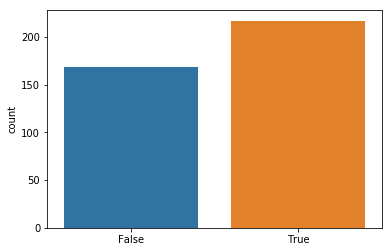

In [114]:
ax = sns.countplot(real_ups[predicted_ups])

In [115]:
pd.value_counts(real_ups[predicted_ups])

True     217
False    168
dtype: int64

# Visualize returns

In [99]:
print('Full data size: ', binary_data.shape[0], ' rows')

Full data size:  4001  rows


In [100]:
print('Train data size: ', X_train.shape[0], ' rows')

Train data size:  3200  rows


In [116]:
test_returns = returns.iloc[X_train.shape[0]:]
test_returns.head()

Date
2012-10-17   -4.503676
2012-10-18   -3.789747
2012-10-19   -0.966892
2012-10-22   -6.502384
2012-10-23   -2.819590
Name: Return, dtype: float64

In [117]:
real_returns = test_returns[predicted_ups]

In [118]:
np.sum(real_returns[real_returns < 0])

-524.1660495526259

In [119]:
np.sum(real_returns[real_returns > 0])

640.0691252395387

In [120]:
np.sum(real_returns)

115.90307568691215

c:\programdata\anaconda3\envs\trading3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


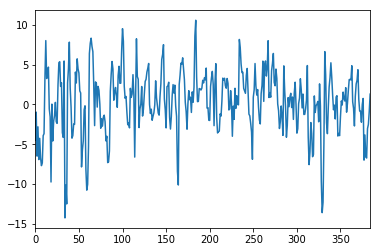

In [121]:
sns.tsplot(real_returns)

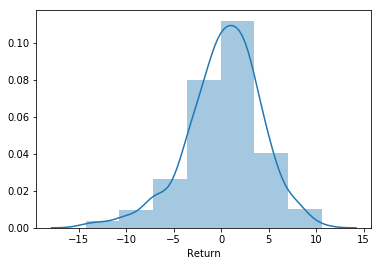

In [124]:
sns.distplot(real_returns, bins=7)

In [125]:
np.sum(test_returns[test_returns < 0])

-1148.8909741265188

In [126]:
np.sum(test_returns[test_returns > 0])

1181.6872417327897

In [127]:
np.sum(test_returns)

32.79626760626971

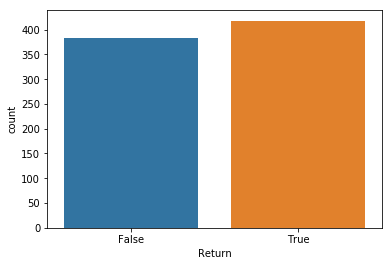

In [111]:
sns.countplot(test_returns > 0)